# NLP

A lo largo del notebook vamos a trabajar con el siguiente dataset:

https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/

En esa competencia de Kaggle también puedes encontrar Notebooks (*kernels*) sumamente interesantes.

El objetivo es que se familiaricen con algunas herramientas típicas del Procesamiento del Lenguaje Natural (NLP por sus siglas en inglés).La biblioteca fundamental que vamos a usar es NLTK. Probablemente tengas que instalarla. Para ello, googlea cómo instalar esta librería con Conda (no olvides activar el ambiente).

Ten en cuenta que la mayoría de las herramientas de NLP pueden ser consideradas como parte del preprocesamiento, llevar el texto a una forma que la computadora pueda entender. En general, esto corresponde a una forma tipo "tabla" al estilo de los DataFrames de Pandas. Es fácil olvidarse de ese objetivo y perderse en todos los pasos. Al principio es común marearse, pero no te preocupes que verás que no es difícil.


## 1. Carga de datos

Lo primero que tienes que hacer es fijarse en qué formato están los datos. ¿De qué se trata es formato?¿Cómo se abre? Si googleas, vas a ver que hay muchas formas de abrir archivos JSON con Python. Como venimos trabajando con Pandas, googlea "Open JSON with Pandas". Prueben esa función. Si les tira un error en el primer intento, googleen el error. Les aseguramos que la respuesta está muy a mano y es muy accesible, no tienen que hacer nada raro.

In [1]:
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk

#Esto sirve para configurar NLTK. La primera vez puede tardar un poco
#nltk.download('punkt')
#nltk.download('stopwords')

In [2]:
dataset = pd.read_json('../datasets/archive_npl/Sarcasm_Headlines_Dataset.json', lines=True)
dataset.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


¿Qué forma tiene el dataset?¿Cuántas instancias?¿Cuáles son sus columnas?¿Cuántos titulares hay de cada tipo?¿Podemos hablar ya de *features*?

In [3]:
dataset.shape

(26709, 3)

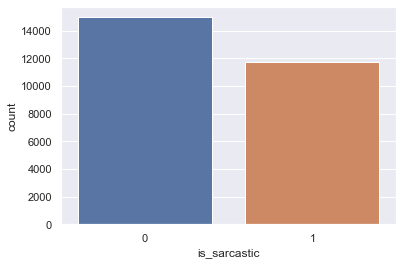

In [4]:
sns.countplot(dataset['is_sarcastic'])
plt.show()

## 2. Breve exploración del dataset

Elige una instancia del dataset al azar y selecciona el *headline*.

In [5]:
index_random = np.random.randint(dataset.shape[0])
titular = dataset.headline.loc[index_random]
print(index_random, titular)

5311 the first 'rogue one' trailer is a 'star wars' nerd's dream


# La administración de Trump parece estar improvisando en las cajas de reemplazo de cupones para alimentos

¿Te parece que es sarcástico?¿Qué características del texto te hace creer - o no - eso? Comprueba si es sarcástico o no imprimiendo en la celda de abajo el valor correspondiente del dataset. (Como la mayoría de los titulares están en inglés y encima refieren a política local, no te preocupes si es una tarea difícil).

In [6]:
print(index_random, dataset.is_sarcastic.loc[index_random])

5311 0


## 3. NLTK

Si es difícil para algunos humanos detectar el sarcasmo, probablemente también lo sea para una computadora. De todas formas, se puede hacer el intento. Para ello, es necesario extraer características de cada texto que nos sirvan para ir apuntando al objetivo. En los videos de Acámica hay muchos ejemplo de herramientas para aplicar. Elegir un titular que les llame la atención y probar las siguientes herramientas:

### Tokenización

¿Qué es y para qué sirve?¿Cuáles de todas las formas de tokenización presentadas te parece más útil para este problema?

1. `sent_tokenize`

In [7]:
titular_st = nltk.sent_tokenize(titular)
titular_st

["the first 'rogue one' trailer is a 'star wars' nerd's dream"]

2. `word_tokenize`

In [8]:
titular_wt = nltk.word_tokenize(titular)
titular_wt

['the',
 'first',
 "'rogue",
 'one',
 "'",
 'trailer',
 'is',
 'a',
 "'star",
 'wars',
 "'",
 'nerd',
 "'s",
 'dream']

### Normalización

¿Qué es y para qué sirve? Notar que varias formas de normalización ya vienen aplicadas en el dataset.

1. Stopwords

Importar los `stopwords` del inglés e imprimirlos.

In [9]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
#stopwords

¿Les parece conveniente aplicar todos los stopwords que aparecen en esa lista?

Eliminar del titular elegido los stopwords.

In [10]:
titular_wt_sin_sw = [palabra for palabra in titular_wt if palabra not in stopwords]
titular_wt_sin_sw

['first',
 "'rogue",
 'one',
 "'",
 'trailer',
 "'star",
 'wars',
 "'",
 'nerd',
 "'s",
 'dream']

¿Cuál o cuáles palabras se fueron?

In [11]:
np.array(set(titular_wt).symmetric_difference(titular_wt_sin_sw))

array({'is', 'the', 'a'}, dtype=object)

### Frecuencia de palabras

Dado el titular ya tokenizado por palabras y sin stopwords, usar `nltk` para extrar la frecuencia con que aparece cada palabras. ¿Tiene sentido esto para titulares?

In [12]:
freq = nltk.probability.FreqDist(titular_wt_sin_sw)
freq

FreqDist({"'": 2, 'first': 1, "'rogue": 1, 'one': 1, 'trailer': 1, "'star": 1, 'wars': 1, 'nerd': 1, "'s": 1, 'dream': 1})

### Dataset Completo

Antes de pasar a extraer features de cada instancia del Dataset, podemos hacer un pequeño análisis del dataset en su conjunto. Por ejemplo, una opción es agrupar todos los titulares por tipo y extraer de cada clase las palabras más frecuentes. Para ello:

1. Agrupar los titulares por tipo. Crear un dataframe para cada uno. Recuerden usar máscaras.
2. Crear una lista vacia y agregar en esa lista todos los titulares (por tipo/dataframe creado) ya tokenizados (usar el `RegexpTokenizer`) y filtrado por `stopwords`.
3. Usar el `FreqDist` en esa lista que acaban de llenar. Llevar lo que devuelve `FreqDist` a un Dataframe. Ordenar por frecuencia en que aparece cada palabra.
4. Hacer un `barplot` o similar para visualizar.
5. ¿Qué palabras filtrarían, aparte de las que aparecen en `stopwords`? Crear una lista vacía y agregarlas a mano. Agregar en el código que realizaron una línea (similar a la que usan con `stopwords`) para que también filtre por esas palabras.
6. Volver a visualizar.

#### No-Sarcasmo

In [13]:
dataset_no_sarcasmo = dataset[dataset["is_sarcastic"]==0]
dataset_no_sarcasmo.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0


In [14]:
todos_titulares_no_sarcasmo = []
for i in np.array(dataset_no_sarcasmo.index):
    titular = dataset_no_sarcasmo.headline.loc[i] #seleccionar el titular
    titular = nltk.tokenize.RegexpTokenizer(r'[\w]+').tokenize(titular)
    #titular = nltk.word_tokenize(titular)
    titular = [palabra for palabra in titular if palabra not in stopwords] # Filtrar por stopwords
    todos_titulares_no_sarcasmo.append(titular) #agregar el resultado a la lista

In [15]:
# Esta celda convierte una lista de listas en una unica lista
todos_titulares_no_sarcasmo = list(itertools.chain(*todos_titulares_no_sarcasmo))
todos_titulares_no_sarcasmo[0:10]

['former',
 'versace',
 'store',
 'clerk',
 'sues',
 'secret',
 'black',
 'code',
 'minority',
 'shoppers']

In [16]:
#FreqDist
freq_no_sarcasmo = nltk.probability.FreqDist(todos_titulares_no_sarcasmo)
freq_no_sarcasmo

FreqDist({'trump': 1446, 'new': 680, 'donald': 458, 'says': 349, 'women': 317, 'one': 268, 'u': 263, 'year': 244, 'first': 242, 'world': 241, ...})

In [23]:
# googlear: how to get pandas dataframe from freqdist
df_no_sarcasmo =  pd.DataFrame.from_dict(freq_no_sarcasmo, orient='index')
df_no_sarcasmo.head()

,0
former,82
versace,1
store,14
clerk,5
sues,15


In [24]:
df_no_sarcasmo.rename(columns={0:'Frecuencia'},inplace=True)

In [25]:
# ordenar por frecuencia
df_no_sarcasmo.sort_values(by='Frecuencia',axis=0, inplace=True, ascending=False)
df_no_sarcasmo.head(10)

,Frecuencia
trump,1446
new,680
donald,458
says,349
women,317
one,268
u,263
year,244
first,242
people,241


In [26]:
df_no_sarcasmo.reset_index(drop = False, inplace=True)
df_no_sarcasmo.head()

,index,Frecuencia
0,trump,1446
1,new,680
2,donald,458
3,says,349
4,women,317


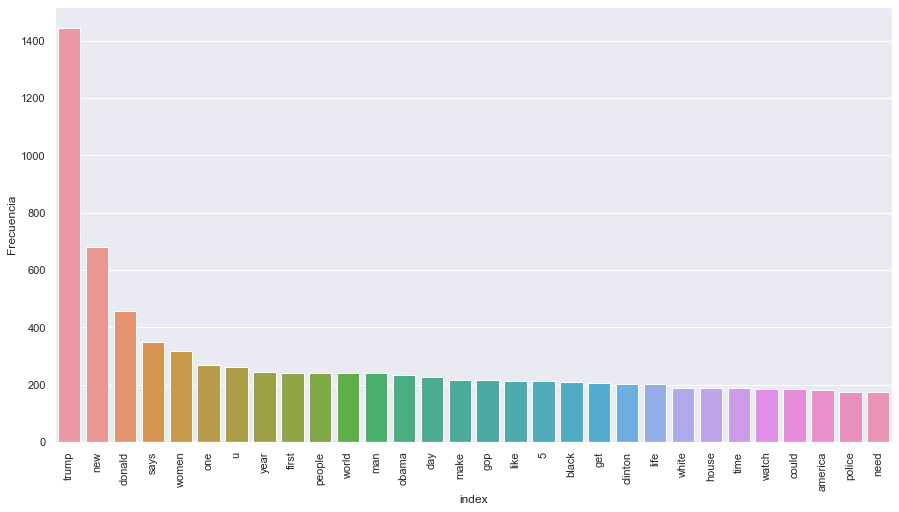

In [33]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_no_sarcasmo.iloc[:30]['index'], y = df_no_sarcasmo.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

#### Sarcasmo

In [34]:
dataset_sarcasmo = dataset[dataset["is_sarcastic"]==1]
dataset_sarcasmo.head()

,article_link,headline,is_sarcastic
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
15,https://entertainment.theonion.com/nuclear-bom...,nuclear bomb detonates during rehearsal for 's...,1
16,https://www.theonion.com/cosby-lawyer-asks-why...,cosby lawyer asks why accusers didn't come for...,1


In [35]:
todos_titulares_sarcasmo = []
for i in np.array(dataset_sarcasmo.index):
    titular = dataset_sarcasmo.headline.loc[i] #seleccionar el titular
    titular = nltk.tokenize.RegexpTokenizer(r'[\w]+').tokenize(titular)
    #titular = nltk.word_tokenize(titular)
    titular = [palabra for palabra in titular if palabra not in stopwords] # Filtrar por stopwords
    todos_titulares_sarcasmo.append(titular) #agregar el resultado a la lista

In [36]:
# Esta celda convierte una lista de listas en una unica lista
todos_titulares_sarcasmo = list(itertools.chain(*todos_titulares_sarcasmo))
todos_titulares_sarcasmo[0:10]

['mom',
 'starting',
 'fear',
 'son',
 'web',
 'series',
 'closest',
 'thing',
 'grandchild',
 'boehner']

In [37]:
#FreqDist
freq_sarcasmo = nltk.probability.FreqDist(todos_titulares_sarcasmo)
freq_sarcasmo

FreqDist({'man': 1154, 'new': 843, 'area': 480, 'report': 426, 'nation': 339, 'woman': 319, 'year': 308, 'one': 273, 'old': 267, 'time': 252, ...})

In [43]:
df_sarcasmo.rename(columns={0:'Frecuencia'},inplace=True)

In [47]:
# ordenar por frecuencia
df_sarcasmo.sort_values(by='Frecuencia',axis=0, inplace=True, ascending=False)
df_sarcasmo.head(10)

,index,Frecuencia
30,man,1154
125,new,843
183,area,480
158,report,426
56,nation,339
184,woman,319
88,year,308
276,one,273
221,old,267
278,time,252


In [38]:
# googlear: how to get pandas dataframe from freqdist
df_sarcasmo =  pd.DataFrame.from_dict(freq_sarcasmo, orient='index')
df_sarcasmo.head()

,0
mom,117
starting,32
fear,16
son,71
web,7


In [39]:
df_sarcasmo.reset_index(drop = False, inplace=True)
df_sarcasmo.head()

,index,0
0,mom,117
1,starting,32
2,fear,16
3,son,71
4,web,7


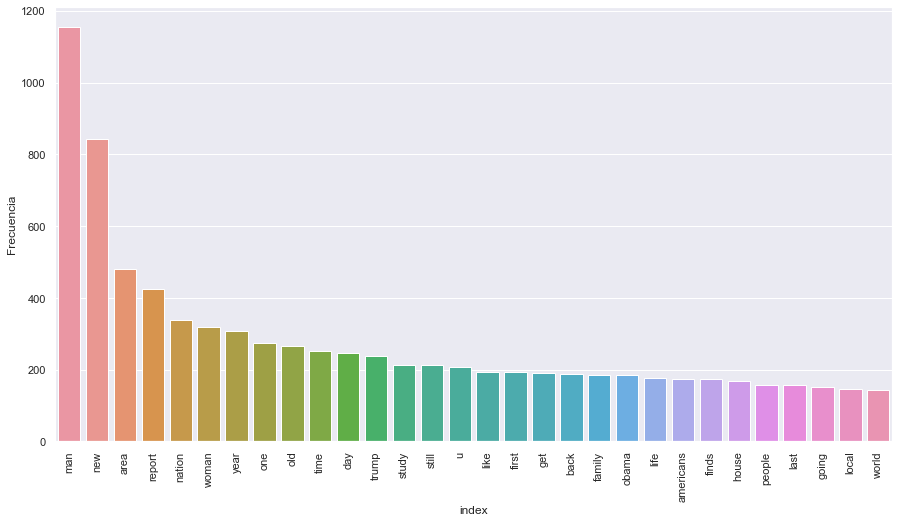

In [48]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_sarcasmo.iloc[:30]['index'], y = df_sarcasmo.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [49]:
filtrar = []
if False:
    filtrar.append("u")
    filtrar.append("new")

## 4. Stemming
Por razones gramaticales muchas palabras pueden escribirse de manera distinta (debido a conjugación, género, número) pero tener el mismo significado para el texto. Por ejemplo si decimos "jugar", "jugando" o "juega", debido a como estan conjugadas, la computadora puede tratarlas como palabras distintas. Pero, en términos de significado, todas estan relacionadas al verbo Jugar. Muchas veces nos va a convenir unir todas estos términos en uno solo.

Una de las manera de hacer esto es por "STEMMING". El Stemming es un proceso eurístico que recorta la terminación de las palabras, agrupándolas por su raiz. Reduzcamos la cantidad de palabras diferentes en nuestro dataset utilizando este proceso.

a. Importar nuevamente el dataset completo

In [50]:
dataset = pd.read_json('../datasets/archive_npl/Sarcasm_Headlines_Dataset.json', lines=True)
dataset.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


b. Tomar del `dataset` solo las columnas de interes

In [54]:
dataset = dataset[['headline','is_sarcastic']]
dataset.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


c. Antes de realizar el proceso de Stemming, vamos a normalizar el texto de la manera que ya estuvimos viendo. Le agregamos en este caso el uso de la libreria `re`, que nos permite sacar del texto todos los caracteres que no sean palabras. Notemos que hay veces que no conviene quitar estos caracteres ya que, por ejemplo, no podremos distiguir preguntas (?) o exclamaciones (!).

In [55]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Traemos nuevamente las stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [56]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
titular_list=[]
for titular in dataset.headline:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras del titular
    titular= nltk.word_tokenize(titular)
    # Eliminamos las palabras de menos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if palabra not in stopwords]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    titular = [stemmer.stem(palabra) for palabra in titular]
    # Por ultimo volvemos a unir el titular
    titular = " ".join(titular)
    
    # Vamos armando una lista con todos los titulares
    titular_list.append(titular)

d. Agregamos al dataset una columna llamado `titular_stem` que contenga los titulares stemmizados

In [58]:
dataset["titular_stem"] = titular_list
dataset.tail()

,headline,is_sarcastic,titular_stem
26704,american politics in moral free-fall,0,american polit moral free fall
26705,america's best 20 hikes,0,america best hike
26706,reparations and obama,0,repar obama
26707,israeli ban targeting boycott supporters raise...,0,isra target boycott support rais alarm abroad
26708,gourmet gifts for the foodie 2014,0,gourmet gift foodi


e. Armamos un nuevo dataset llamado `dataset_stem` que contenga solo las columnas `titular_stem` e `is_sarcastic`

In [61]:
dataset_stem = dataset[['titular_stem','is_sarcastic']]
dataset_stem.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
dataset_stem.head()

C:\Anaconda3\envs\acamica\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,titular_stem,is_sarcastic
0,former versac store clerk sue secret black cod...,0
1,roseann reviv catch thorni polit mood better wors,0
2,start fear seri closest thing grandchild,1
3,boehner want wife listen come altern debt redu...,1
4,rowl wish snape happi birthday magic,0


## 5. Lemmatization

Otra manera de llevar distintas palabras a un raíz común en la que comparten un significado es mediante el procezo de 'Lemmatizar' el texto. Es similar al 'Stemming' pero un poco más educado, ya que intenta realizar el proceso teniendo en cuenta cuál es el rol que la palabra cumple en el texto. Esto quiere decir que su accionar será distinto si la palabra a lemmantizar está actuando como verbo, sustantivo, etc. 

Para usar las funciones que ofrece `nltk` para lemmantizar, tendremos primero que descargar la libreria `Wordnet` que se encuentra en la solapa 'corpora' y las librerias 'maxent_treebank_pos_' y 'averaged_perceptron_tagger' que se encuentra en la solapa 'Models'. Para eso ejecute la siguiente celda:

In [ ]:
nltk.download()

In [63]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

Veamos cómo actúa el lemmatizer sobre una frase de ejemplo.

In [64]:
# Oracion que usaremos como ejemplo
frase = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."

# Hay que regularizar el texto. Dejar solo letra, pasar a minúsculas y tokenizar:

# Sacamos todo lo que no sean letras
frase = re.sub("[^a-zA-Z]"," ",str(frase))
# Pasamos a minúsculas
frase = frase.lower()
# Tokenizamos
frase_tokens = nltk.word_tokenize(frase)

# Veamos como cambians las palabras al lemmatizar
print("{0:20}{1:20}".format("Word","Lemma"))
for palabra in frase_tokens:
    print ("{0:20}{1:20}".format(palabra,wordnet_lemmatizer.lemmatize(palabra)))

Word                Lemma               
he                  he                  
was                 wa                  
running             running             
and                 and                 
eating              eating              
at                  at                  
same                same                
time                time                
he                  he                  
has                 ha                  
bad                 bad                 
habit               habit               
of                  of                  
swimming            swimming            
after               after               
playing             playing             
long                long                
hours               hour                
in                  in                  
the                 the                 
sun                 sun                 


¿Te sorprende lo que paso? No cambiaron casi nada (solo se fueron las "s" del final). El problema es que precisamos darle información extra al Lemmatizer, decirle qué rol está cumpliendo la palabra en la oración. Si se fijan en la documentación, esto se hace pasandole un argumento extra a la función llamado POS (Part Of Speech).

Hay distintos metodos que intentan averiguar el rol que cumple una palabra en una oración. Nosotros vamos a utilizar uno que viene incorporado en NLTK llamado pos_tag.

In [65]:
print(nltk.pos_tag(frase_tokens))

[('he', 'PRP'), ('was', 'VBD'), ('running', 'VBG'), ('and', 'CC'), ('eating', 'VBG'), ('at', 'IN'), ('same', 'JJ'), ('time', 'NN'), ('he', 'PRP'), ('has', 'VBZ'), ('bad', 'JJ'), ('habit', 'NN'), ('of', 'IN'), ('swimming', 'NN'), ('after', 'IN'), ('playing', 'VBG'), ('long', 'JJ'), ('hours', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('sun', 'NN')]


Las etiquetas refieren al tipo de palabra. Vamos a definir una función para traducir estas etiquetas a los valores de POS que entiende `wordnet_lemmatizer`.

In [66]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

Veamos finalmente como funciona en nuestro ejemplo.

In [67]:
frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(frase)]
tipo_palabra = [get_wordnet_pos(w) for w in nltk.word_tokenize(frase)]

# Veamos como cambiaron las palabras
print("{0:20}{1:20}{2:20}".format("Palabra:","Tipo:","Lemma:"))
for i in range(len(frase_tokens)):
    print ("{0:20}{1:20}{2:20}".format(frase_tokens[i],tipo_palabra[i],frase_lemma[i]))

Palabra:            Tipo:               Lemma:              
he                  n                   he                  
was                 v                   be                  
running             v                   run                 
and                 n                   and                 
eating              v                   eat                 
at                  n                   at                  
same                a                   same                
time                n                   time                
he                  n                   he                  
has                 v                   have                
bad                 a                   bad                 
habit               n                   habit               
of                  n                   of                  
swimming            v                   swim                
after               n                   after               
playing             v   

a. Ahora te toca aplicar todo esto a nuestro dataset. Vamos a volver a importarlo y hacer un procedimiento análogo al que hicimos para la parte de Stemming.

In [71]:
# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Importamos esta libreria que nos permite reemplzar caracteres
import re

dataset = pd.read_json('../datasets/archive_npl/Sarcasm_Headlines_Dataset.json', lines=True)
dataset = dataset[['headline','is_sarcastic']]
dataset.dropna(axis=0,inplace=True)

# Traemos nuevamente las stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [75]:
titular_list=[]
for titular in dataset.headline:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular = re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular = titular.lower()
    # Tokenizamos para separar las palabras
    titular = nltk.word_tokenize(titular)
    
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    titular = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in titular]
    
    
    # Eliminamos las palabras d emenos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if palabra not in stopwords]
    
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    #dataset["titular_normalizado"] = titular_list
    titular_list.append(titular)

In [76]:
dataset["titular_lemm"] = titular_list
dataset.tail()

,headline,is_sarcastic,titular_lemm
26704,american politics in moral free-fall,0,american politics moral free fall
26705,america's best 20 hikes,0,america best hike
26706,reparations and obama,0,reparation obama
26707,israeli ban targeting boycott supporters raise...,0,israeli target boycott supporter raise alarm a...
26708,gourmet gifts for the foodie 2014,0,gourmet gift foodie


b. Por último nos armamos un nuevo datasate llamado `dataset_lem` que tenga solo las columnas `titular_lemm` y `is_sarcastic`.

In [77]:
dataset_lemm = dataset[['titular_lemm','is_sarcastic']]
dataset_lemm.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
dataset_lemm.head()

C:\Anaconda3\envs\acamica\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,titular_lemm,is_sarcastic
0,former versace store clerk secret black code m...,0
1,roseanne revival catch thorny political mood well,0
2,start fear series closest thing grandchild,1
3,boehner want wife listen come alternative debt...,1
4,rowling wish snape happy birthday magical,0


**Para mirar**: toma algunos titulares al azar y compara su versión `dataset_lemm` y en `dataset_stem`. Explica.

## 6. Vectorizar

Hasta ahora, tenemos un grupo de palabras por cada titular (bag of words), ya sea *lemmatizado* o *stemmizado*. ¿Te parece que esto servirá para entrenar modelos? La idea ahora es representar esta lista de palabras como un vector. Para esto vamos a utilizar la función `CountVectorizer` de Scikit-Learn. Esta función nos permite representar cada título por un vector con un `1` en las palabras que contiene y un `0` en las que no. Además, vamos a trabajar únicamente con las palabras que aparecen más veces en el texto, ya que las que aparecen una única vez o pocas veces no nos van a brindar información que se pueda generalizar.

a. Tomamos la lista de palabras y el vector que nos dice si es o no sarcástico el título

In [78]:
# Tomamso la lista de palabras y el vector que nos dice si es o no sarcastico el titulo
list_titulos = list(dataset_lemm['titular_lemm'])
is_sarc = dataset_lemm['is_sarcastic']

## Para probar con Stemmizer:
#list_titulos = list(dataset_stem'titular_stem'].values)
#is_sarc = dataset_stem['is_sarcastic'].values

b. Preparamos el conversor de bag of words a vectores que traemos de sklearn. `CountVectorizer` posee varias funcionalidades que pueden determinarse a partir de parámetros. Les recomendamos fuertemente leer su documentación.

In [79]:
from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

Notemos que desde `CountVectorizer` se pueden quitar las stopwords (algo que ya hicimos con `nltk`) e incluir los n_gramas automáticamente.

c. Ahora sí, vamos generarnos los vectores para cada título a partir del corpus total.

In [80]:
matriz_titulos = cou_vec.fit_transform(list_titulos)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abortion', 'abuse', 'accidentally', 'accord', 'accuse', 'across', 'action', 'activist', 'actor', 'actually', 'address', 'administration', 'admits', 'adorable', 'advice', 'afghanistan', 'agent', 'ahead', 'airline', 'airport', 'album', 'allegation', 'allow', 'almost', 'already', 'also', 'always', 'amaze', 'amazon', 'america', 'american', 'amid', 'among', 'animal', 'anniversary', 'announce', 'announces', 'another', 'answer', 'anti', 'anyone', 'anything', 'apartment', 'apologizes', 'apparently', 'appear', 'apple', 'archive', 'area', 'around']


## 7. Modelar

Ahora sí estamos listos para usar todo nuestro conocimiento de modelos en este set de datos. Tengamos en cuenta que, dependiendo el número de palabras (features) que hayamos elegido, los modelos pueden tardar un rato en entrenarse.

a. Primero, como siempre, separamos en test y train.

In [81]:
x = matriz_titulos.toarray()
y = is_sarc

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

Tambien definimos una función que nos permite plotear los resultados en una matriz de confusión.

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["No Sarcastico","Sarcastico"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### Naive Bayes
a. Empecemos por un simple Naive Bayes para tener un benchmark de referencia para el accuracy.

In [84]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)

print("acc : ", nb.score(xtest,ytest))

acc :  0.6679146387120929


b. Veamos cómo queda graficada la matriz de confusión:

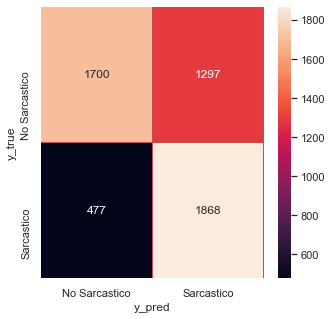

In [85]:
y_pred = nb.predict(xtest)
confusion(ytest,y_pred)

### Random Forest
a. Veamos cómo funciona un random forest para predecir el sarcasmo de una nota en base a su titular.

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier()
rf.fit(X=xtrain,y=ytrain)

print("acc : ", rf.score(xtest,ytest))

acc :  0.708910520404343


b. Grafiquen su matriz de confusión:

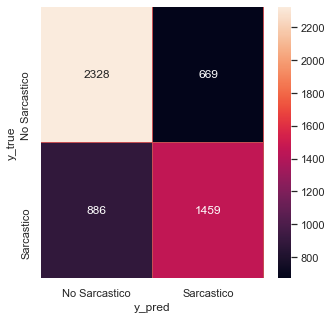

In [89]:
y_pred = rf.predict(xtest)
confusion(ytest,y_pred)

c. Habíamos dicho que algo muy bueno de Random Forest era poder preguntarle por la importancia de los features que uso para clasificar. Veamos en este caso cuales son las palabras que mayormente determinan el sarcasmo de una nota para este clasificador.

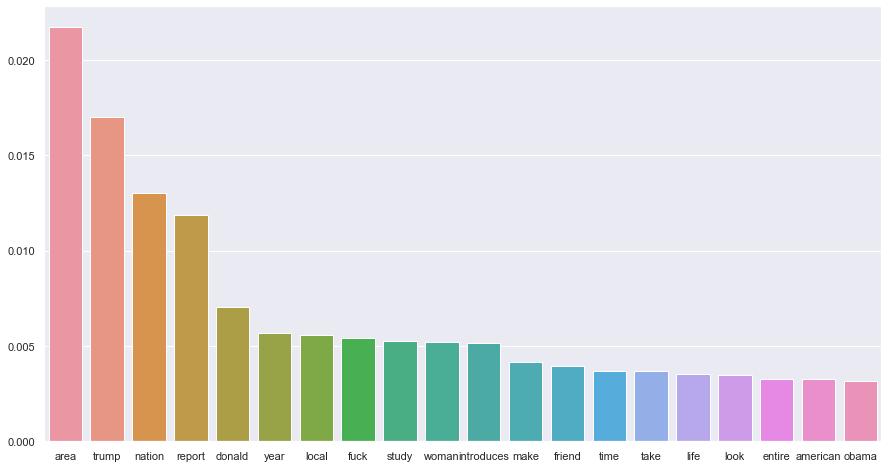

In [90]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

### SVM
Por último vamos a utilizar uno de los modelos mas prometedores para este tipo de datos donde el numero de features es comparable al número de instancias: SVM.

a. Entrene un modelo de SVM Lineal y calcule su accuracy para C = 1.

In [92]:
# Notar que en vez de utilizar SVC, vamos a usar LinearSVC. 
# Para el Kernel Lineal, esta función es MUCHO mas rapida que la tradicional SVC.
from sklearn.svm import LinearSVC

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)

print("acc : ", svc.score(xtest,ytest))

acc :  0.7278172968925496


b. Grafiquen su matrz de confusión:

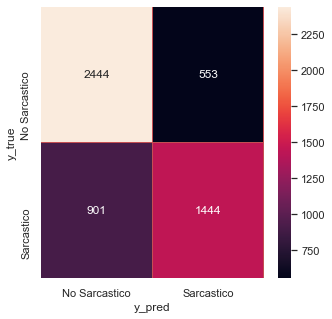

In [93]:
y_pred = svc.predict(xtest)
confusion(ytest,y_pred)

## 7. Explora las posibilidades

Si llegaste hasta acá, ya cuentas con todas las herramientas para poder explorar qué sucede con el poder predictivo cuando van cambiando la manera en que procesas y vectorizas el texto. Algunas sugerencias para explorar son las siguientes:

1. Prueba con Stemmizar en vez de lemmantizar
1. Cambia el numero de features que esta tomando.
1. Prueba con TF-IDF.
1. Incluye los 2-gramas. ¿Qué era eso?
1. Conserve los signos de exclamación y pregunta del texto.
